# GNEU0001-1 - Tutorial 4 - Neural rate modeling

## Instructions

- This homework must be carried out individually

- This homework is due by **December 9, 2022 at 10pm**.


## Gradescope submission

Submission must be done on the [Gradescope](https://www.gradescope.com/) platform directly.

- Each student must register on [Gradescope](https://www.gradescope.com/) using his address `@student.uliege.be`. If you don"t see the GNEU0001 course in your dashboard, contact us as soon as possible (don"t wait until the day before the submission date to check that you have access to the course on Gradescope ;-).

- Each student must submit only one `.ipynb` file on [Gradescope](https://www.gradescope.com/). All cells must be executable and their outputs must not be cleared before submission. 

If you are unfamiliar with Gradescope, you will find explanations of each submission step below:
- [Code Submission](https://help.gradescope.com/article/ccbpppziu9-student-submit-work#code_submissions).

---
## 0. Getting started

To get started, make sure you the bellow packages installed in your environment.

In [1]:
import Pkg; Pkg.add("Parameters")
import Pkg; Pkg.add("DifferentialEquations")
import Pkg; Pkg.add("Roots")
import Pkg; Pkg.add("Plots")


begin   
    using Parameters
    using DifferentialEquations
    using Roots
    using Plots             # for plotting stuff
    default(fmt = :png)     # for keeping an reasonnable size for the notebook 
end

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


### Plotting functions

In [2]:
function plot_fI(x, f)
    p = plot(x, f, label=:none)
    plot!(xlabel="x (a.u.)", ylabel="F(x)")
    display(p)
end

function plot_dr_r(r, drdt, x_fps=nothing)
    p = plot(r, drdt, label=:none)
    if !isnothing(x_fps)
        plot!(x_fps, zeros(length(x_fps)), linetype=:scatter, markershape=:o, label=:none)
        println(x_fps)
    end
    
    plot!(r, zeros(length(r)), color=:black, linestyle=:dash, label=:none)
    plot!(xlabel="r", ylabel="dr/dt")
    plot!(ylims=(-0.5, 0.5))
    display(p)
end

plot_dr_r (generic function with 2 methods)

---
## 1. Neuronal network dynamics

### 1.1. Dynamics of a single excitatory population

Individual neurons respond by spiking. When we average the spikes of neurons in a population, we can define the average firing activity of the population. In this model, we are interested in how the population-averaged firing varies as a function of time and network parameters. Mathematically, we can describe the firing rate dynamic of a feed-forward network as:
\begin{equation*}
\tau \frac{dr}{dt} = -r + F(w \cdot r + I_{\text{ext}}).
\end{equation*}

$r(t)$ represents the average firing rate of the excitatory population at time $t$, $\tau$ controls the timescale of the evolution of the average firing rate, $I_{\text{ext}}$ represents the external input, and the transfer function $F(\cdot)$ (which can be related to f-I curve of individual neurons described in the next sections) represents the population activation function in response to all received inputs.

To start building the model, execute the cell below to initialize the simulation parameters.

In [3]:
@with_kw struct default_pars_single

    # Excitatory parameters
    tau = 1.     # Timescale of the E population [ms]
    a = 1.2      # Gain of the E population
    theta = 2.8  # Threshold of the E population

    # Connection strength
    w = 0.      # E to E, we first set it to 0

    # External input
    I_ext = 0.
    Iapp = t->I_ext 

    # Simulation parameters
    T = 20.       # Total duration of simulation [ms]
    dt = .1       # Simulation time step [ms]
    r_init = 0.2  # Initial value of E

end

pars = default_pars_single()
print(pars)

default_pars_single
  tau: Float64 1.0
  a: Float64 1.2
  theta: Float64 2.8
  w: Float64 0.0
  I_ext: Float64 0.0
  Iapp: #10 (function of type var"#10#14"{Float64})
  T: Float64 20.0
  dt: Float64 0.1
  r_init: Float64 0.2


You can now use:
- `pars = default_pars_single()` to get all the parameters;
- `pars = default_pars_single(I_ext = I_ext, tau = tau)` to set new external current and time constant;
- `@unpack tau, a, theta, w  = pars` to unpack parameters;
- `pars.a` to access the parameter `a` in `pars`.

### 1.2. F-I curves

Let's first investigate the activation functions before simulating the dynamics of the entire population. 

In this exercise, you will implement a sigmoidal **F-I** curve or transfer function $F(x)$, with gain $a$ and threshold level $\theta$ as parameters:
\begin{equation*}
F(x;a,\theta) = \frac{1}{1+\text{e}^{-a(x-\theta)}} - \frac{1}{1+\text{e}^{a\theta}}.
\end{equation*}

**TO DO:**
- Implement the function $F$ given above.
- Plot the function $F$ for different values of $a$ and $\theta$.
- How does the gain parameter ($a$) affect the F-I curve?
- How does the threshold parameter ($\theta$) affect the F-I curve?

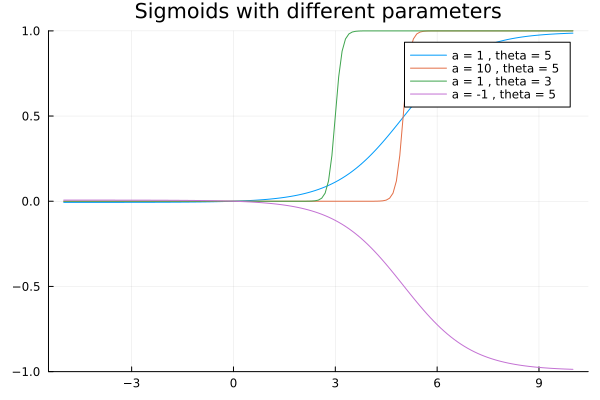

In [4]:
function F(x, a, theta)
    """
    Population activation function.
    Args:
        x (float): the population input
        a (float): the gain of the function
        theta (float): the threshold of the function
    Returns:
        float: the population activation response F(x) for input x
    """

    # Define the sigmoidal transfer function f = F(x)
    f = (1 ./ (1 .+ (exp.(x .- theta) .^ (-a)))) .- (1 / (1 + exp(a*theta)) )

    return f
end
  
# Set parameters
pars = default_pars_single()  # get default parameters
x = -5:0.1:10     # set the range of input

# Compute transfer function
f = F(x, 1, 5)
# Visualize
p1 = plot(x, f, ylims = (-1,1), label = "a = 1 , theta = 5")
title!("Sigmoids with different parameters")

f = F(x, 10, 5)
plot!(x, f,label = "a = 10 , theta = 5")

f = F(x, 10, 3)
plot!(x, f, label = "a = 1 , theta = 3")

f = F(x, -1, 5)
plot!(x, f, label = "a = -1 , theta = 5")


### 1.3. Simulation scheme of E dynamics

Because $F(\cdot)$ is a nonlinear function, the exact solution of our differential equation of population activity can not be determined via analytical methods. As we have seen before, we can use numerical methods, specifically the Euler method, to find the solution (that is, simulate the population activity).

In [5]:
function simulate_single(pars)
    # Set parameters
    @unpack tau, a, theta, w  = pars
    @unpack Iapp = pars
    @unpack r_init, T, dt = pars

    f(u,p,t) = 1/tau * (-u + F(w * u +  Iapp(t), a, theta))
    
    # Set simulation parameters and problem
    u0 = r_init
    tspan = (0.0,T)
    prob = ODEProblem(f, u0, tspan)

    # Solve
    sol = solve(prob, saveat=dt)

    return sol
end

simulate_single (generic function with 1 method)

**TO DO:**

Explore these dynamics of the population activity.
- How does $r_{\text{sim}}(t)$ change with different $I_{\text{ext}}$ values? 
- How does it change with different $\tau$ values? 

Note that, $r_{\rm ana}(t)$ denotes the analytical solution (when $w=0$), which is what we are studying here.

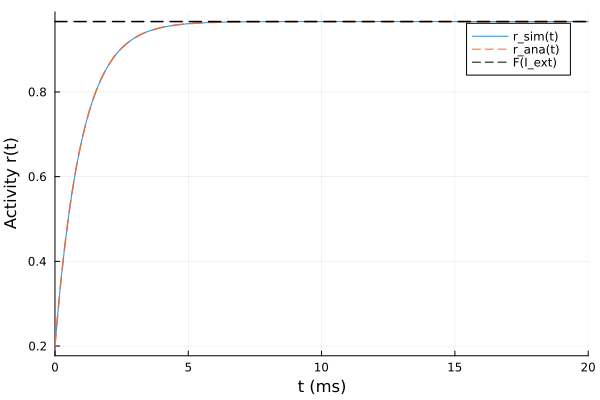

In [6]:
pars = default_pars_single(T=20.)

function Myplot_E_diffI_difftau(I_ext, tau)
    # set external input and time constant
    pars = default_pars_single(I_ext = I_ext, tau = tau)

    # set parameters
    @unpack tau, a, theta, w, I_ext, r_init, T, Iapp = pars

    # simulation
    sol = simulate_single(pars)
    
    # analytical Solution
    r_ana = pars.r_init .+ (F.(I_ext, pars.a, pars.theta) .- pars.r_init) .* (1. .- exp.(-sol.t ./ tau))

    p = plot(sol, label="r_sim(t)")
    plot!(sol.t, r_ana, linestyle=:dash, label="r_ana(t)",linewidth=1.5)
    plot!(sol.t, F.(Iapp.(sol.t), a, theta), color=:black, linestyle=:dash, label="F(I_ext)",linewidth=1.5 )
    plot!(xlabel = "t (ms)", ylabel="Activity r(t)",linewidth=1.5)
    display(p)
end

I_ext = 10
tau = 1
Myplot_E_diffI_difftau(I_ext, tau)

**TO THINK:**

Above, we have numerically solved a system driven by a positive input. Yet, $r_E(t)$ either decays to zero or reaches a fixed non-zero value.

1. Why doesn't the solution of the system "explode" in a finite time? In other words, what guarantees that $r_E$(t) stays finite? 
2. Which parameter would you change in order to increase the maximum value of the response? 

### Student response

1) The solution does not explode and converges to a value because the magnitude of the gradient of the differential equation is strictly decreasing.
It is a first order ODE that converges towards the value of Iext.

We can also see that the value of the analytical solution is bounded by [r_init + 0 + 0 , r_init + 1 + 1] in the worst case.

2) I_ext as it will converge to sigmoid(I_ext)

---
## 2. Fixed points of the single population system

### 2.1. Finding fixed points

#### 2.1.1. Visualization of the fixed points

When it is not possible to find the solution for the dynamics analytically, a graphical approach can be taken. To that end, it is useful to plot $\displaystyle{\frac{dr}{dt}}$ as a function of $r$. The values of $r$ for which the plotted function crosses zero on the y axis correspond to fixed points. 

Here, let us, for example, set $w=5.0$ and $I^{\text{ext}}=0.5$. From the dynamics, you can obtain
\begin{equation}
\frac{dr}{dt} = [-r + F(w\cdot r + I^{\text{ext}})]\,/\,\tau.
\end{equation}

**TO DO:**
- Plot the $dr/dt$ as a function of $r$.

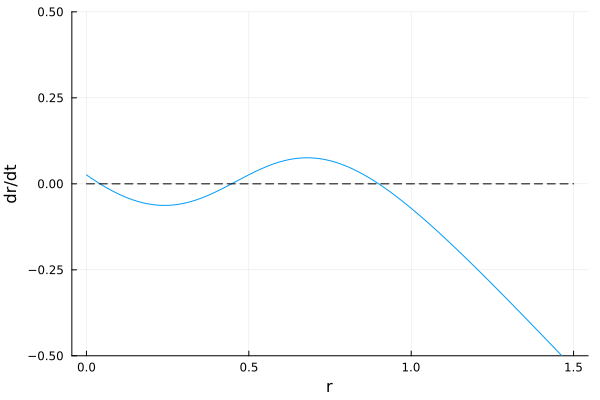

In [7]:
function compute_drdt(r, pars)
  """Given parameters, compute dr/dt as a function of r.

  Args:
    r (1D array) : Average firing rate of the excitatory population
    I_ext, w, a, theta, tau (numbers): Simulation parameters to use
    other_pars : Other simulation parameters are unused by this function

  Returns
    drdt function for each value of r
  """
  # Set parameters
  @unpack tau, a, theta, w, I_ext = pars

  # Calculate drdt
  drdt = (1/tau) * (-r .+ F(w .* r .+ I_ext, a, theta) ) 

  return drdt
end


# Define a vector of r values and the simulation parameters
r = range(0, stop=1.5, length=10000)

pars = default_pars_single(I_ext=0.5, w=5)

# Compute dr/dt
drdt = compute_drdt(r, pars)

# Visualize
plot_dr_r(r, drdt)

#### 2.1.2. Numerical calculation of fixed points

We will now find the fixed points numerically. To do so, we need to specify initial values ($r_{\text{guess}}$) for the root-finding algorithm to start from. From the line $\displaystyle{\frac{dr}{dt}}$ plotted above in the last exercise, initial values can be chosen as a set of values close to where the line crosses zero on the y axis (real fixed point).

The next cell defines three helper functions that we will use:

- `my_fp_single(r_guess, pars)` uses a root-finding algorithm to locate a fixed point near a given initial value;
- `check_fp_single(x_fp, pars, mytol)` verifies that the values of $r_{\rm fp}$ for which $\displaystyle{\frac{dr}{dt}} = 0$ are the true fixed points;
- `my_fp_finder(r_guess_vector, pars, mytol)` accepts an array of initial values and finds the same number of fixed points, using the above two functions.

**TO DO:**
- Plot the $dr/dt$ as a function of $r$.
- Check for the presence of fixed points.
- Overlay the fixed points on the plot.

In [8]:
function my_fp_single(r_guess, pars)
  """
  Calculate the fixed point through drE/dt=0

  Args:
    r_guess  : Initial value used for scipy.optimize function
    a, theta, w, I_ext : simulation parameters

  Returns:
    x_fp    : value of fixed point
  """

  @unpack tau, a, theta, w, I_ext = pars

  # define the right hand of E dynamics
  function my_WCr(x)
    y = (-x .+ F.(w .* x .+ I_ext, a, theta))
    return y
  end

  x_fp = find_zero(my_WCr, r_guess)

  return x_fp
end


function check_fp_single(x_fp, pars, mytol)
  """
   Verify |dr/dt| < mytol

  Args:
    fp      : value of fixed point
    a, theta, w, I_ext: simulation parameters
    mytol   : tolerance, default as 10^{-4}

  Returns :
    Whether it is a correct fixed point: True/False
  """

  @unpack tau, a, theta, w, I_ext = pars

  # calculate Equation(3)
  y = x_fp - F.(w .* x_fp .+ I_ext, a, theta)

  # Here we set tolerance as 10^{-4}
  return abs(y) < mytol
end


function my_fp_finder(r_guess_vector, pars, mytol)
  """
  Calculate the fixed point(s) through drE/dt=0

  Args:
    pars    : Parameter dictionary
    r_guess_vector  : Initial values used for scipy.optimize function
    mytol   : tolerance for checking fixed point, default as 10^{-4}

  Returns:
    x_fps   : values of fixed points

  """
  x_fps = []
  correct_fps = []
  for r_guess in r_guess_vector
    x_fp = my_fp_single(r_guess, pars)
    if check_fp_single(x_fp, pars, mytol)
      push!(x_fps, x_fp)
    end
  end

  return x_fps
end

my_fp_finder (generic function with 1 method)

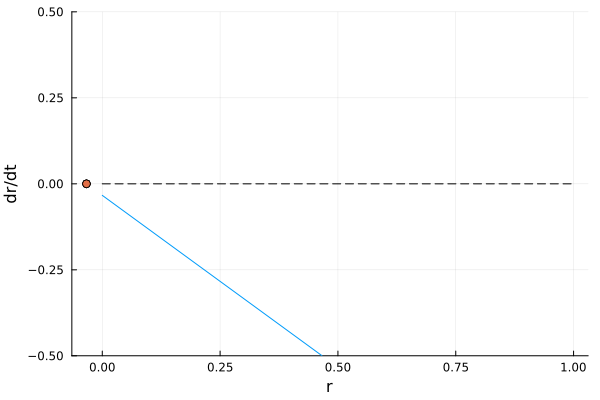

Any[-0.03356900108802869, -0.03356900108802869, -0.03356900108802869]
Any[-0.03356900108802869, -0.03356900108802869, -0.03356900108802869]hey


In [9]:
# Set parameters
r = range(0, stop=1, length = 1000)
pars = default_pars_single(I_ext=-10, w=-1)

# Compute dr/dt
drdt = compute_drdt(r, pars)

# Initial guesses for fixed points
r_guess_vector = (0.05, 0.4, 0.85)

# Find fixed point numerically
mytol = 1e-4
x_fps = my_fp_finder(r_guess_vector, pars,  mytol)

# # Visualize
plot_dr_r(r, drdt, x_fps)

print(x_fps)
print("hey\n")
flush(stdout)

**TO DO:**

You can now explore how the previous plot changes when the recurrent coupling $w$ and the external input $I_{\text{ext}}$ take different values. How does the number of fixed points change?

## Student Response :

Changing Iapp translates the function vertically. At a fixed w, if Iapp is too high it will destroy the left-most fixed points and only keep the rightmost fixed point at a high r value. Lowering Iapp also reduces the number of fixed points, if Iapp is too low, only a fixed point at a 0 rate is present in the system. There are intermediate values of Iapp for some w where there can be up to 3 fixed points.

Regarding w, it distorts the shape of the function. Decreasing w flattens the function and can even make it strictly decreasing. This destroys the ability to have several concurrent fixed points in the system. Increasing w accentuates the shape of the curve and shifts the minimum and maximum of the curve towards a center value. Unlike decreasing the value of w, here the number of possible concurrent fixed points in the system does not change but the value of those fixed points do change.

### 2.2. Relationship between trajectories & fixed points

Let's examine the relationship between the population activity over time and the fixed points.

Here, let us first set $w=5.0$ and $I_{\text{ext}}=0.5$, and investigate the dynamics of $r(t)$ starting with different initial values $r(0) \equiv r_{\text{init}}$.

**TO DO:**
- Plot the trajectories of $r(t)$ with $r_{\text{init}} = 0.0, 0.1, 0.2,..., 0.9, 1.0$.

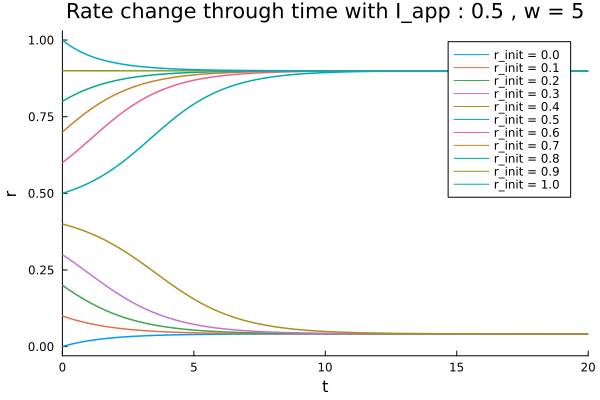

In [10]:
p = plot(ylabel = "r")
pars = default_pars_single(I_ext=0.5, w=5)
for ie in range(0, stop=10)
    pars = default_pars_single(pars; r_init=0.1 * ie)  # set the initial value
    sol = simulate_single(pars)
    plot!(sol,linewidth=1.5,grid=false,label = ("r_init = " * string((round(ie*0.1,digits = 3)))) ,title="Rate change through time with I_app : 0.5 , w = 5")

end
display(p)

We have three fixed points but only two steady states showing up - what's happening? 

It turns out that the stability of the fixed points matters. If a fixed point is stable, a trajectory starting near that fixed point will stay close to that fixed point and converge to it (the steady state will equal the fixed point). If a fixed point is unstable, any trajectories starting close to it will diverge and go towards stable fixed points. In fact, the only way for a trajectory to reach a stable state at an unstable fixed point is if the initial value **exactly** equals the value of the fixed point.

Which of the fixed points for the model we've been examining in this section are stable vs unstable?

We can simulate the trajectory if we start at the unstable fixed point: you can see that it remains at that fixed point (the red line below).

**TO DO:**
- Plot all previous trajectories and the trajectory from the unstable fixed point.

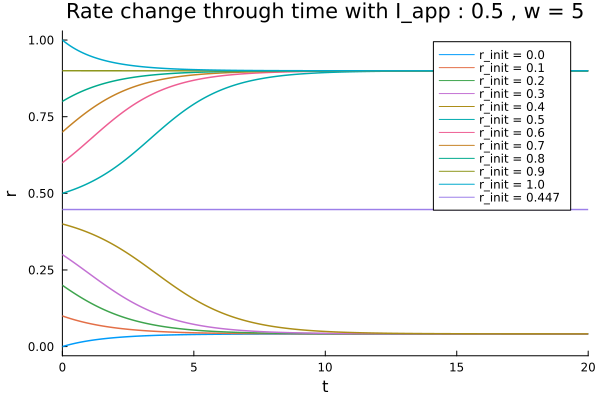

In [11]:
p = plot(ylabel = "r")
pars = default_pars_single(I_ext=0.5, w=5)

# Find fixed point numerically
mytol = 1e-4
x_fps = my_fp_finder([0.01, 0.5, 0.90], pars,  mytol)

for ie in range(0, stop=10)
    pars = default_pars_single(pars; r_init=0.1 * ie)  # set the initial value
    sol = simulate_single(pars)
    plot!(sol,linewidth=1.5,grid=false,label = ("r_init = " * string((round(ie*0.1,digits = 3)))) ,title="Rate change through time with I_app : 0.5 , w = 5")

end
pars = default_pars_single(pars; r_init=x_fps[2])  # set the initial value
sol = simulate_single(pars)
plot!(sol,linewidth=1.5,grid=false,label = "r_init = " * string((round(x_fps[2],digits = 3))),title="Rate change through time with I_app : 0.5 , w = 5")

**TO THINK:**

Throughout the tutorial, we have assumed $w> 0 $, i.e., we considered a single population of **excitatory** neurons. What do you think will be the behavior of a population of inhibitory neurons, i.e., where $w> 0$ is replaced by $w< 0$? 

---
## 3. Wilson-Cowan model of excitatory and inhibitory populations

### 3.1 Mathematical description of the WC model

Many of the rich dynamics recorded in the brain are generated by the interaction of excitatory and inhibitory subtype neurons. Here, similar to what we did in the previous tutorial, we will model two coupled populations of E and I neurons (**Wilson-Cowan** model). We can write two coupled differential equations, each representing the dynamics of the excitatory or inhibitory population:

\begin{align*}
\tau_E \frac{dr_E}{dt} &= -r_E + F_E(w_{EE}r_E -w_{EI}r_I + I^{\text{ext}}_E;a_E,\theta_E)\\
\tau_I \frac{dr_I}{dt} &= -r_I + F_I(w_{IE}r_E -w_{II}r_I + I^{\text{ext}}_I;a_I,\theta_I)   
\end{align*}

$r_E(t)$ represents the average activation (or firing rate) of the excitatory population at time $t$, and $r_I(t)$ the activation (or firing rate) of the inhibitory population. The parameters $\tau_E$ and $\tau_I$ control the timescales of the dynamics of each population. Connection strengths are given by: $w_{EE}$ (E $\rightarrow$ E), $w_{EI}$ (I $\rightarrow$ E), $w_{IE}$ (E $\rightarrow$ I), and $w_{II}$ (I $\rightarrow$ I). The terms $w_{EI}$ and $w_{IE}$ represent connections from inhibitory to excitatory population and vice versa, respectively. The transfer functions (or F-I curves) $F_E(x;a_E,\theta_E)$ and $F_I(x;a_I,\theta_I)$ can be different for the excitatory and the inhibitory populations.

In [12]:
@with_kw struct default_pars

  # Excitatory parameters
  tau_E = 1.     # Timescale of the E population [ms]
  a_E = 1.2      # Gain of the E population
  theta_E = 2.8  # Threshold of the E population

  # Inhibitory parameters
  tau_I = 2.0    # Timescale of the I population [ms]
  a_I = 1.0      # Gain of the I population
  theta_I = 4.0  # Threshold of the I population

  # Connection strength
  wEE = 9.   # E to E
  wEI = 4.   # I to E
  wIE = 13.  # E to I
  wII = 11.  # I to I

  # External input
  I_ext_E = 0.
  I_ext_I = 0.

  # simulation parameters
  T = 50.        # Total duration of simulation [ms]
  dt = .1        # Simulation time step [ms]
  rE_init = 0.2  # Initial value of E
  rI_init = 0.2  # Initial value of I

  # Vector of discretized time points [ms]
  range_t = range(0, stop = T, step = dt)

end

pars = default_pars()
print(pars)

default_pars
  tau_E: Float64 1.0
  a_E: Float64 1.2
  theta_E: Float64 2.8
  tau_I: Float64 2.0
  a_I: Float64 1.0
  theta_I: Float64 4.0
  wEE: Float64 9.0
  wEI: Float64 4.0
  wIE: Float64 13.0
  wII: Float64 11.0
  I_ext_E: Float64 0.0
  I_ext_I: Float64 0.0
  T: Float64 50.0
  dt: Float64 0.1
  rE_init: Float64 0.2
  rI_init: Float64 0.2
  range_t: StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}


**TO DO:** 
- Plot out the F-I curves for the E and I populations using the helper function `F` with default parameter values.

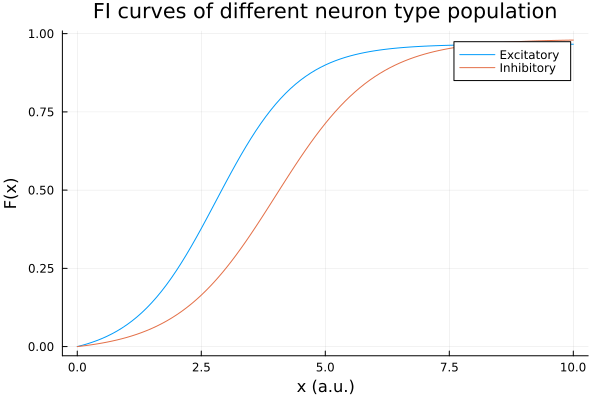

In [13]:
pars = default_pars()
x = range(0, stop = 10, step = .1)

# Compute the F-I curve of the excitatory population
FI_exc = F(x,pars.a_E,pars.theta_E)

# Compute the F-I curve of the inhibitory population
FI_inh = F(x,pars.a_I,pars.theta_I)

# Visualize
p = plot(x, FI_exc, label= "Excitatory")
plot!(x, FI_inh, label= "Inhibitory")
plot!(xlabel="x (a.u.)", ylabel="F(x)", title = "FI curves of different neuron type population")
display(p)

### 3.2: Numerically integrate the Wilson-Cowan equations

We will implement this numerical simulation of our equations and visualize two simulations with similar initial points.

**TO DO:**
- Plot the trajectories for $r_{E}(0) = 0.32$, $r_{I}(0) = 0.15$.
- Plot the trajectories for $r_{E}(0) = 0.33$, $r_{I}(0) = 0.15$.

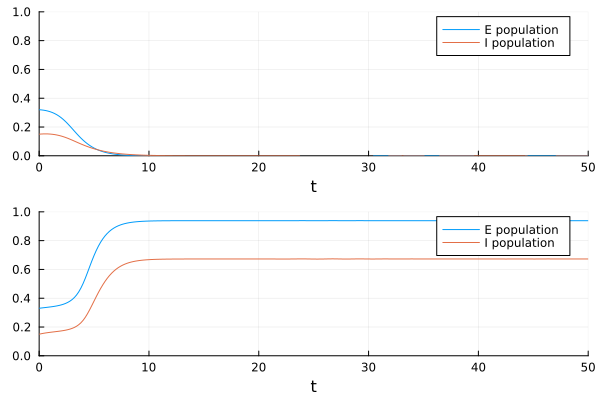

In [14]:
function simulate_wc(pars)
  """
  Simulate the Wilson-Cowan equations
  Args:
    Parameters of the Wilson-Cowan model
  Returns:
    rE, rI (arrays) : Activity of excitatory and inhibitory populations
  """

  @unpack tau_E, a_E, theta_E, tau_I, a_I, theta_I, wEE, wEI, wIE, wII, I_ext_E, I_ext_I, rE_init, rI_init, dt, range_t, T = pars

  function f!(du,u,p,t)
    rE = u[1]
    rI = u[2]

    drE = (1/tau_E) * (-rE + F(wEE*rE - wEI*rI + I_ext_E, a_E, theta_E))
    drI = (1/tau_I) * (-rI + F(wIE*rE - wII*rI + I_ext_I, a_I, theta_I))

    du[1] = drE
    du[2] = drI
  end

  u0 = [rE_init;rI_init]
  tspan = (0.0,T)
  prob = ODEProblem(f!, u0, tspan)
  sol = solve(prob, saveat=0.2)

  return sol
end

pars1 = default_pars(rE_init = 0.32, rI_init = 0.15)
# Simulate first trajectory
sol1 = simulate_wc(pars1)

pars2 = default_pars(rE_init = 0.33, rI_init = 0.15)
# Simulate second trajectory
sol2 = simulate_wc(pars2)

# Visualize
p1 = plot(sol1, idxs=(0,1), label="E population")
plot!(sol1, idxs=(0,2), label="I population")
plot!(ylims=(0,1))

p2 = plot(sol2, idxs=(0,1), label="E population")
plot!(sol2, idxs=(0,2), label="I population")
plot!(ylims=(0,1))

p = plot(p1, p2, layout=(2,1))

The two plots above show the temporal evolution of excitatory ($r_E$, blue) and inhibitory ($r_I$, red) activity for two different sets of initial conditions.

What happens to the E and I population trajectories with different initial conditions?

## Student response

The equilibrium point and behavior of the system changes drastically. In situation 1, the initial rate of the excitatory is not high enough to compensate the effect of the Inhibitory population. The system ends up collapsing to 0 rate in both populations.

In situation 2, the excitatory population is above the threshold where its own influence can increase its activity and compensate for the inhibitory action at the beginning. This increases the activation in both populations until an equilibrium is reached.

### 3.3. Nullclines of the Wilson-Cowan Equations

An important concept in the phase plane analysis is the "nullcline" which is defined as the set of points in the phase plane where the activity of one population (but not necessarily the other) does not change.

In other words, the $E$ and $I$ nullclines of Equation $(1)$ are defined as the points where $\displaystyle{\frac{dr_E}{dt}}=0$, for the excitatory nullcline, or $\displaystyle\frac{dr_I}{dt}=0$ for the inhibitory nullcline. That is:
\begin{align*}
-r_E + F_E(w_{EE}r_E -w_{EI}r_I + I^{\text{ext}}_E;a_E,\theta_E) &= 0 \\
-r_I + F_I(w_{IE}r_E -w_{II}r_I + I^{\text{ext}}_I;a_I,\theta_I) &= 0  .
\end{align*}

Note that, when computing the nullclines with Equations 4-5, we also need to calculate the inverse of the transfer functions.

The inverse of the sigmoid shaped **f-I** function that we have been using is:
\begin{equation}
F^{-1}(x; a, \theta) = -\frac{1}{a} \ln \left[ \frac{1}{x + \displaystyle \frac{1}{1+\text{e}^{a\theta}}} - 1 \right] + \theta \qquad (6)
\end{equation}

The first step is to implement the inverse transfer function.

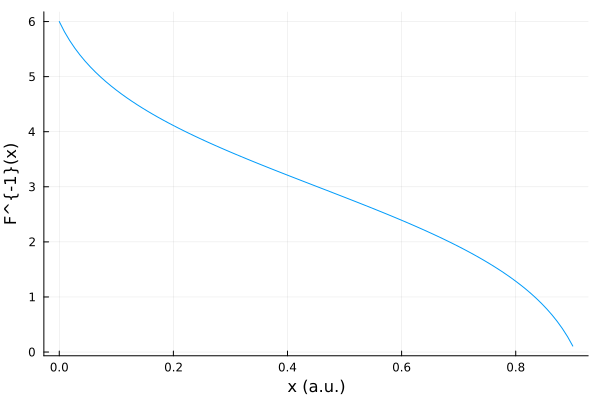

In [15]:
function F_inv(x, a, theta)
  """
  Args:
    x         : the population input
    a         : the gain of the function
    theta     : the threshold of the function
  Returns:
    F_inverse : value of the inverse function
  """

  # Calculate Finverse (ln(x) can be calculated as np.log(x))
  F_inverse = (1/a) .* log.( (1 ./ (x .+ (1 /(1 + exp(a*theta))))) .- 1) .+ theta

  return F_inverse
end


# Set parameters
pars = default_pars()
x = range(1e-6, stop = 0.9, length=100)

# Get inverse and visualize
a=1
theta=3
plot(x, F_inv(x,a, theta), label=:none)
plot!(xlabel="x (a.u.)", ylabel="F^{-1}(x)")

Now you can compute the nullclines (repeated here for ease of access):
\begin{align*}
r_I &= \frac{1}{w_{EI}}\big{[}w_{EE}r_E - F_E^{-1}(r_E; a_E,\theta_E) + I^{\text{ext}}_E \big{]}  \\
r_E &= \frac{1}{w_{IE}} \big{[} w_{II}r_I + F_I^{-1}(r_I;a_I,\theta_I) - I^{\text{ext}}_I \big{]}  
\end{align*}

**TO DO:**
- Compute and plot the nullclines.

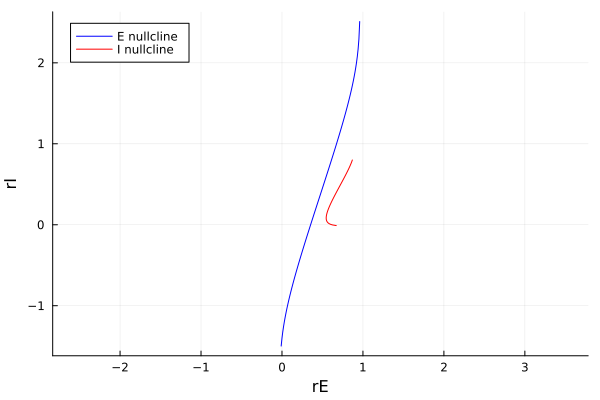

In [16]:
function get_E_nullcline(rE, pars)
  """
  Solve for rI along the rE from drE/dt = 0.
  Args:
    rE    : response of excitatory population
    a_E, theta_E, wEE, wEI, I_ext_E : Wilson-Cowan excitatory parameters
    Other parameters are ignored
  Returns:
    rI    : values of inhibitory population along the nullcline on the rE
  """
  @unpack a_E, theta_E, wEE, wEI, I_ext_E = pars

  # calculate rI for E nullclines on rI
  rI = (1/wEI) .* (wEE.*rE .- F_inv(rE,a_E,theta_E) .+ I_ext_E)

  return rI
end

function get_I_nullcline(rI, pars)
  """
  Solve for E along the rI from dI/dt = 0.
  Args:
    rI    : response of inhibitory population
    a_I, theta_I, wIE, wII, I_ext_I : Wilson-Cowan inhibitory parameters
    Other parameters are ignored
  Returns:
    rE    : values of the excitatory population along the nullcline on the rI
  """
  @unpack a_I, theta_I, wIE, wII, I_ext_I = pars

  # calculate rE for I nullclines on rI
  rE = (1/wIE).*(wII.*rI .+ F_inv(rI,a_I,theta_I) .- I_ext_I)

  return rE
end


# Set parameters
pars = default_pars()
Exc_null_rE = range(-0.01, stop = 0.96, length=100)
Inh_null_rI = range(-0.01, stop = 0.8, length = 100)

# Compute nullclines
Exc_null_rI = get_E_nullcline(Exc_null_rE, pars)
Inh_null_rE = get_I_nullcline(Inh_null_rI, pars)

# Visualize
p = plot(Exc_null_rE, Exc_null_rI, color=:blue, label="E nullcline")
plot!(Inh_null_rE, Inh_null_rI, color=:red, label="I nullcline")
plot!(aspect_ratio=:equal)
plot!(xlabel="rE", ylabel="rI")
plot!(legend=:topleft)

Note that by definition along the blue line in the phase-plane spanned by $r_E, r_I$, $\displaystyle{\frac{dr_E(t)}{dt}} = 0$, therefore, it is called a nullcline. 

That is, the blue nullcline divides the phase-plane spanned by $r_E, r_I$ into two regions: on one side of the nullcline $\displaystyle{\frac{dr_E(t)}{dt}} > 0$ and on the other side $\displaystyle{\frac{dr_E(t)}{dt}} < 0$.

The same is true for the red line along which $\displaystyle{\frac{dr_I(t)}{dt}} = 0$. That is, the red nullcline divides the phase-plane spanned by $r_E, r_I$ into two regions: on one side of the nullcline $\displaystyle{\frac{dr_I(t)}{dt}} > 0$ and on the other side $\displaystyle{\frac{dr_I(t)}{dt}} < 0$.

### 3.4. Vector field

How can the phase plane and the nullcline curves help us understand the behavior of the Wilson-Cowan model? 

The activities of the $E$ and $I$ populations $r_E(t)$ and $r_I(t)$ at each time point $t$ correspond to a single point in the phase plane, with coordinates $(r_E(t),r_I(t))$. Therefore, the time-dependent trajectory of the system can be described as a continuous curve in the phase plane, and the tangent vector to the trajectory, which is defined as the vector $(\displaystyle{\frac{dr_E(t)}{dt},\frac{dr_I(t)}{dt}})$, indicates the direction towards which the activity is evolving and how fast is the activity changing along each axis. In fact, for each point $(E,I)$ in the phase plane, we can compute the tangent vector $(\displaystyle{\frac{dr_E}{dt},\frac{dr_I}{dt}})$, which  indicates the behavior of the system when it traverses that point. 

The map of tangent vectors in the phase plane is called **vector field**. The behavior of any trajectory in the phase plane is determined by i) the initial conditions $(r_E(0),r_I(0))$, and ii) the vector field $(\displaystyle{\frac{dr_E(t)}{dt},\frac{dr_I(t)}{dt}})$.

In general, the value of the vector field at a particular point in the phase plane is represented by an arrow. The orientation and the size of the arrow reflect the direction and the norm of the vector, respectively.

**TO DO:**
- Compute and plot the vector field.
- Overlay the nullclines and two representative trajectories (for the low state and the high state).

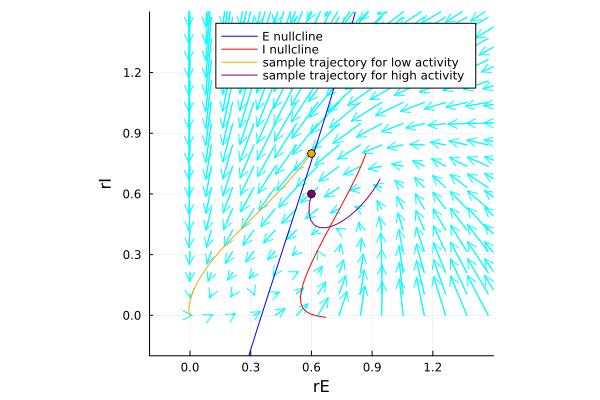

In [45]:
function EIderivs(rE, rI, pars)
  """Time derivatives for E/I variables (dE/dt, dI/dt)."""

  @unpack tau_E, a_E, theta_E, wEE, wEI, I_ext_E, tau_I, a_I, theta_I, wIE, wII, I_ext_I = pars

  # Compute the derivative of rE
  drEdt = -rE .+ F(wEE.*rE .- wEI.*rI .+ I_ext_E,a_E,theta_E )

  # Compute the derivative of rI
  drIdt = -rI .+ F(wIE.*rE .- wII.*rI .+I_ext_I,a_I,theta_I)

  return drEdt, drIdt
end


# Simulate first trajectory
sol1 = simulate_wc(default_pars(rE_init=.6, rI_init=.8))

# Simulate second trajectory
sol2 = simulate_wc(default_pars(rE_init=.6, rI_init=.6))

# plot vector field
EI_grid = range(0., stop = 2., length = 20)
meshgrid(x, y) = (repeat(x, outer=length(y)), repeat(y, inner=length(x)))
rE, rI = meshgrid(EI_grid, EI_grid)
drEdt, drIdt = EIderivs(rE, rI, pars)

sc = 5

p = quiver(rE, rI,quiver=(drEdt/sc, drIdt/sc), color=:cyan)
plot!(Exc_null_rE, Exc_null_rI, color=:blue, label="E nullcline")
plot!(Inh_null_rE, Inh_null_rI, color=:red, label="I nullcline")
plot!(sol1, idxs=(1,2), color=:orange, label="sample trajectory for low activity")
plot!([sol1[1][1]], [sol1[1][2]], markershape=:o, color=:orange, label=:none)
plot!(sol2, idxs=(1,2), color=:purple, label="sample trajectory for high activity")
plot!([sol2[1][1]], [sol2[1][2]], markershape=:o, color=:purple, label=:none)
plot!(aspect_ratio=:equal)
plot!(xlabel="rE", ylabel="rI")
plot!(xlims=(-0.2,1.5),ylims=(-0.2,1.5))
display(p)

### 3.5. Limit cycle - Oscillations

For some values of interaction terms ($w_{EE}, w_{IE}, w_{EI}, w_{II}$), the eigenvalues can become complex. When at least one pair of eigenvalues is complex, oscillations arise. 
The stability of oscillations is determined by the real part of the eigenvalues (+ve real part oscillations will grow, -ve real part oscillations will die out). The size of the complex part determines the frequency of oscillations. 

For instance, if we use a different set of parameters, $w_{EE}=6.4$, $w_{EI}=4.8$, $w_{IE}=6.$, $w_{II}=1.2$, and $I_{E}^{\text{ext}}=0.8$, then we shall observe that the E and I population activity start to oscillate! Please execute the cell below to check the oscillatory behavior. 

**TO DO:**
- Plot the trajectories as a function of time.
- Plot the nullclines, the vector field, and a trajectory in the phase plane.

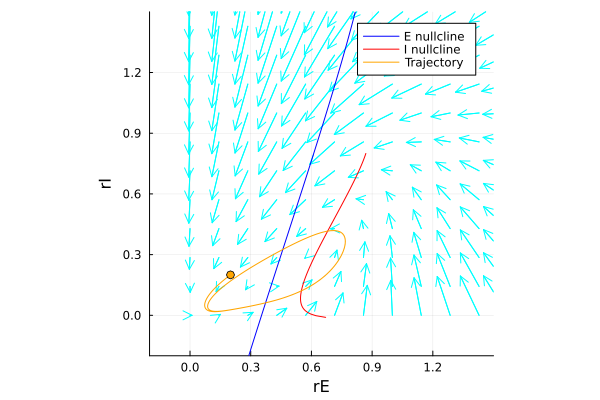

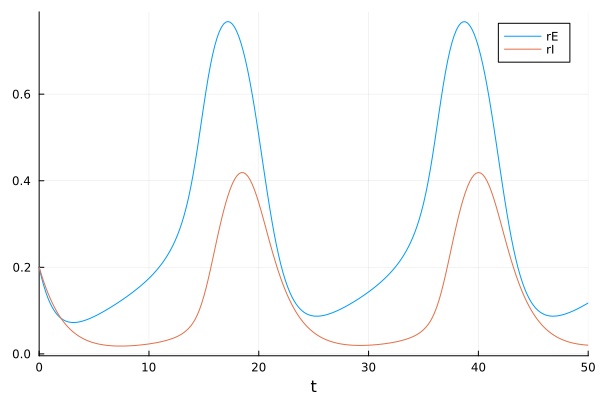

In [48]:
pars = default_pars(wEE = 6.4 , wEI = 4.8 , wIE = 6, wII = 1.2, I_ext_E = 0.8)

# Simulate trajectory
sol1 = simulate_wc(pars)

# plot vector field
EI_grid = range(0., stop = 2., length = 15)
meshgrid(x, y) = (repeat(x, outer=length(y)), repeat(y, inner=length(x)))
rE, rI = meshgrid(EI_grid, EI_grid)
drEdt, drIdt = EIderivs(rE, rI, pars)

sc = 5

p = quiver(rE, rI,quiver=(drEdt/sc, drIdt/sc), color=:cyan)
plot!(Exc_null_rE, Exc_null_rI, color=:blue, label="E nullcline")
plot!(Inh_null_rE, Inh_null_rI, color=:red, label="I nullcline")
plot!(sol1, idxs=(1,2), color=:orange, label="Trajectory")
plot!([sol1[1][1]], [sol1[1][2]], markershape=:o, color=:orange, label=:none)
plot!(aspect_ratio=:equal)
plot!(xlabel="rE", ylabel="rI")
plot!(xlims=(-0.2,1.5),ylims=(-0.2,1.5))
display(p)

p2 = plot(sol1, label = ["rE" "rI"])
display(p2)